In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import pickle

In [4]:
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)

In [5]:
pk_NN = []
pk_i=[]
pk_pgd=[]
for filename in os.listdir("/data/CAMELS/Sims/PM_sims/lambda12_1/"):
        res =pickle.load(open(os.path.join('/data/CAMELS/Sims/PM_sims/lambda12_1/', filename), 'rb'))
        pk_NN.append(res['pk_NN'])
        pk_pgd.append(res['pk_pgd'])
        pk_i.append(res['pk_i'])
k=res['k']

In [6]:
mupk_NN=stack(pk_NN).mean(axis=0)
mupk_pgd=stack(pk_pgd).mean(axis=0)
mupk_i=stack(pk_i).mean(axis=0)

In [7]:
snapshots = jnp.array([
 0.14285714254594556,
 0.16666666542893738,
 0.1999999986832461,
 0.22222222150378537,
 0.24999999806336917,
 0.2622410627683301,
 0.27508150213837845,
 0.2885506615021642,
 0.3026793308840415,
 0.3174997972262324,
 0.3330459395932943,
 0.3493532841474449,
 0.36645910890451366,
 0.38440250769880274,
 0.4032244880783829,
 0.42296807642809625,
 0.4436783909454936,
 0.46540277468080926,
 0.4881908767722827,
 0.5120947767731064,
 0.5371691181575536,
 0.5634712010003641,
 0.5910611509374005,
 0.6200020223344457,
 0.6503599561823248,
 0.682204349649582,
 0.7156079737852235,
 0.7506471880986196,
 0.7874020715837913,
 0.8259566232460903,
 0.8663989774339641,
 0.9088215533213413,
 0.9533213274239392,
 0.9999999999999998])

In [8]:
pk_ref = jc.power.nonlinear_matter_power(cosmo, k, snapshots[::2][-1])


/local/home/dl264294/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4457: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


In [9]:
import cmasher as cmr
import matplotlib.colors as colors

cmap = cmr.eclipse  
col = cmr.eclipse([0.,0,0.55,0.85]) 

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0., vmax=1))

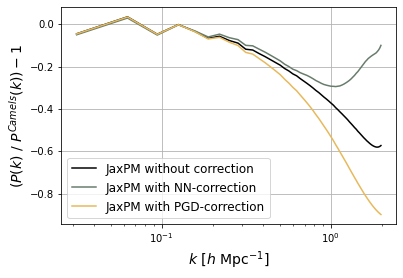

In [10]:
semilogx(k, (mupk_i/pk_ref)-1,label='JaxPM without correction',color=col[1])
semilogx(k, (mupk_NN/pk_ref)-1,label='JaxPM with NN-correction',color=col[2])    
semilogx(k, (mupk_pgd/pk_ref)-1,label='JaxPM with PGD-correction',color=col[3]) 
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)
plt.ylabel(r"$ (P(k) \ / \ P^{Camels}(k))-1$",fontsize=14)
plt.grid(True)
legend(fontsize='large')